## Signal-Like tritium training data


1. Exclude S2-only events
2. S1 vs S2 uncorrected area - make a box cut around tritium data
<br> Cut low S1 area population,handscan using eventviewer
4. Drift time against S2_x_cm^2 + S2_y_cm^2 cut 
5. Apply 2 and 3 on Bad area vs S2 corrected area plot
6. Threshold Cut: 1D histogram of s2-area. lower threshold cut, upper threshold cut = 50 electrons
<br> Do this for both:
<br> - S2 only events (hence dont apply drift cuts)
<br> - No S2 only events

In [258]:
import uproot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from scipy.optimize import curve_fit
import os

%matplotlib notebook

In [259]:
#if Helen 
os.chdir(r"C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data")
#if Trinity
#os.chdir(r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project")

#1. exclude S2-only events 
with uproot.open("ch3t_sr1_fixed.root") as f:
    arr = f["Events"].arrays(cut = 'S1_corrected_area > 0', library = 'pd')
arr.keys()

Index(['runID', 'evtID', 'S2_area', 'S2_btm_area', 'S2_top_area', 'S2_TBA',
       'S2_corrected_area', 'S2_XY_corrected_area', 'S2_width_ns',
       'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25', 'S2_AFT_50',
       'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns', 'S2_fwhm_ns',
       'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated', 'has_good_S1',
       'drift_time', 'S1_area', 'S1_corrected_area', 'evt_total_area',
       'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area'],
      dtype='object')

<IPython.core.display.Javascript object>


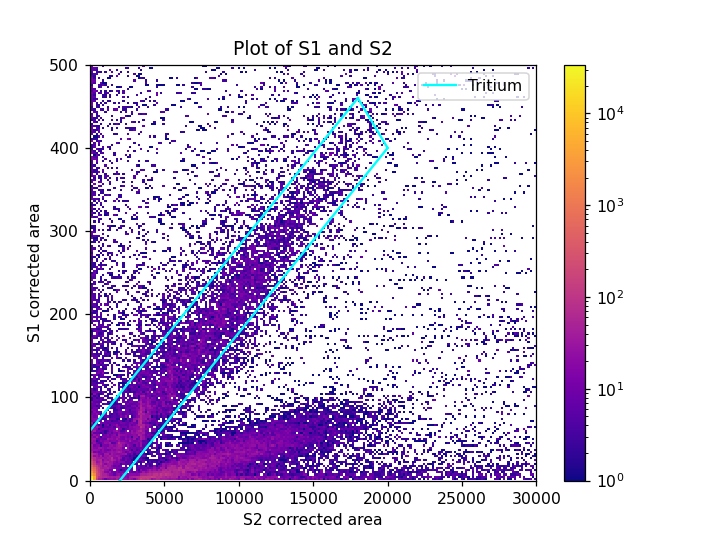

In [260]:
fig, ax = plt.subplots()
conditions= (arr['S1_corrected_area']<500) & (arr['S2_corrected_area']<30000)

#Tight cut
line1 = plt.Line2D((2000, 20000), (0, 400), color = 'cyan', label="Tritium")
line2 = plt.Line2D((0, 18000), (60, 460), color = 'cyan')
line3 = plt.Line2D((20000, 18000), (400, 460), color = 'cyan')

#Plot
h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)

plt.ylim(0, 500)
plt.xlim(0, 30000)
plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Plot of S1 and S2')
plt.legend(loc='upper right')
plt.show()

#for line1
m = 400 / 18000
c1 = -40 

#for line2
m = 400 / 18000
c2 = 60 

In [261]:
#save cut to Tritium-like array
def line(x, m, c):
    y = (m * x) + c
    return y

tritium_like_arr = arr.copy(deep=True)
print ("Tritium Array length at start (no cuts): ",len(tritium_like_arr))

tritium_like_arr = tritium_like_arr[(tritium_like_arr['S1_corrected_area']>line(tritium_like_arr['S2_corrected_area'], m, c1)) & (tritium_like_arr['S1_corrected_area']<line(tritium_like_arr['S2_corrected_area'], m, c2))& (tritium_like_arr['S1_corrected_area']<460)& (tritium_like_arr['S2_corrected_area']<20000)]
print("Tritium Array Length (S1/S2 Cut): ",len(tritium_like_arr))

Tritium Array length at start (no cuts):  1246490
Tritium Array Length (S1/S2 Cut):  115970


<IPython.core.display.Javascript object>


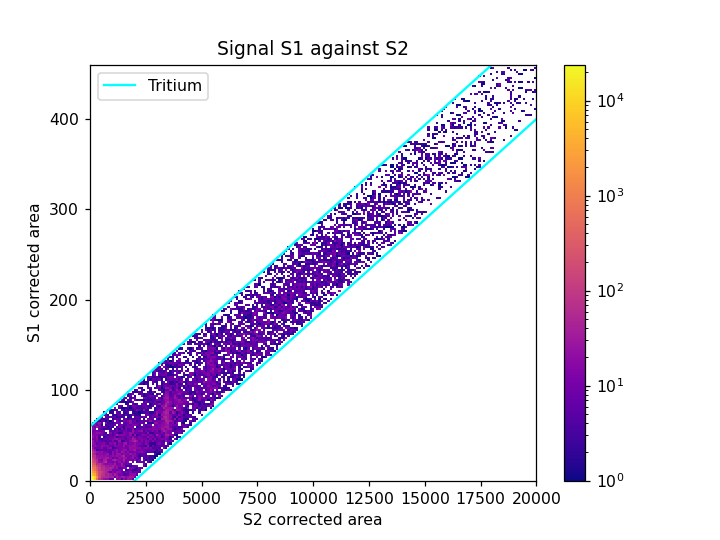

In [262]:
#Isolating Tritium
fig, ax = plt.subplots()

line1 = plt.Line2D((2000, 20000), (0, 400), color = 'cyan', label="Tritium")
line2 = plt.Line2D((0, 18000), (60, 460), color = 'cyan')

h = ax.hist2d(tritium_like_arr['S2_corrected_area'], 
              tritium_like_arr['S1_corrected_area'],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())

fig.colorbar(h[3], ax=ax)

ax.add_line(line1)
ax.add_line(line2)
plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Signal S1 against S2')
plt.ylim(0, 460)
plt.xlim(0, 20000)
plt.legend()
plt.show()

In [38]:
#get event ID for Tritium-like and low S1 events
#Tritium-like
#print(tritium_like_arr[['runID', 'evtID']].to_string(index=False))

<IPython.core.display.Javascript object>


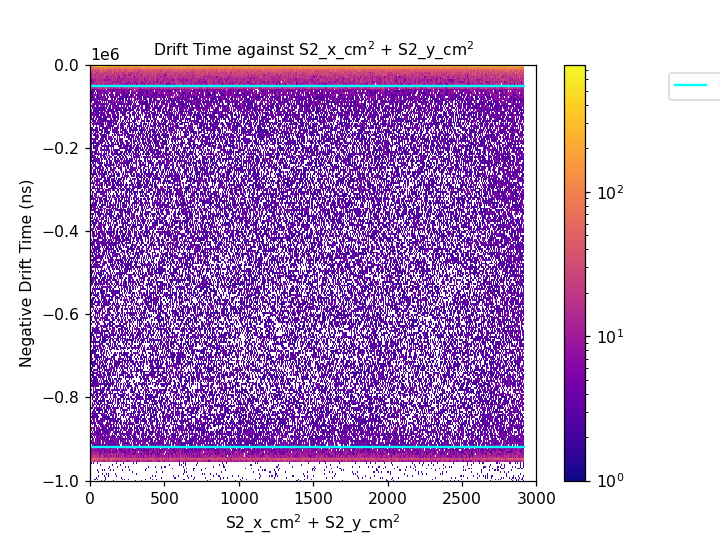

In [263]:
#3. Drift time against S2_x_cm^2 + S2_y_cm^2

x2y2= np.square(arr['S2_x_cm'])+np.square(arr['S2_y_cm'])
negdt=np.multiply(arr['drift_time'],-1)

fig, ax = plt.subplots()
#Straight cut lines
line1 = plt.Line2D((0, 2916), (-0.05e6, -0.05e6), color = 'cyan', label="Cut")
line2 = plt.Line2D((0, 2916), (-0.92e6, -0.92e6), color = 'cyan')

h = ax.hist2d(x2y2,negdt,bins=1000, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlim(0,3000)
plt.ylim(-1e6,0)

ax.add_line(line1)
ax.add_line(line2)

plt.xlabel('S2_x_cm$^{2}$ + S2_y_cm$^{2}$')
plt.ylabel('Negative Drift Time (ns)')
plt.title('Drift Time against S2_x_cm$^{2}$ + S2_y_cm$^{2}$',size=10)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

In [264]:
#save cut to Tritium-like array
tritium_like_arr = tritium_like_arr[(np.multiply(tritium_like_arr['drift_time'],-1)>-0.94e6) & (np.multiply(tritium_like_arr['drift_time'],-1)<-0.05e6)]
print("Tritium Array Length (drift time cut): ",len(tritium_like_arr))

Tritium Array Length (drift time cut):  49839


<IPython.core.display.Javascript object>


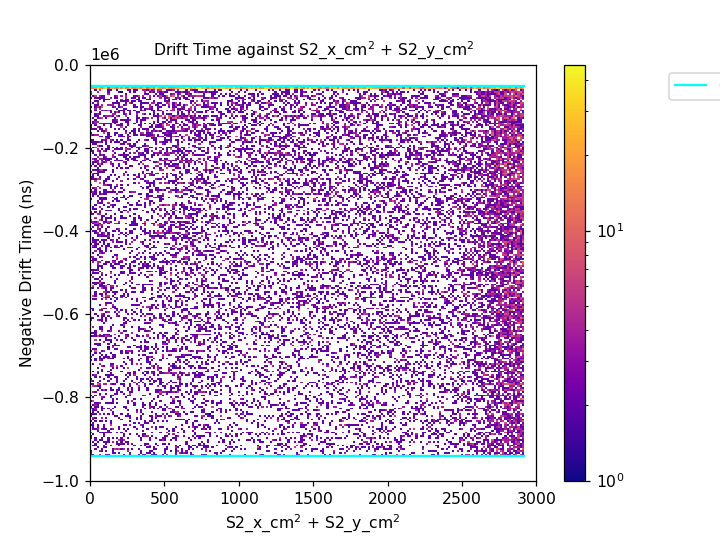

In [265]:
#2 Drift time against S2_x_cm^2 + S2_y_cm^2 WITH cuts
fig, ax = plt.subplots()

x2y2= np.square(tritium_like_arr['S2_x_cm'])+np.square(tritium_like_arr['S2_y_cm'])
negdt=np.multiply(tritium_like_arr['drift_time'],-1)

line1 = plt.Line2D((0, 2916), (-0.05e6, -0.05e6), color = 'cyan', label="Cut")
line2 = plt.Line2D((0, 2916), (-0.94e6, -0.94e6), color = 'cyan')


h = ax.hist2d(x2y2,negdt,               
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
plt.xlim(0,3000)
plt.ylim(-1e6,0)

ax.add_line(line1)
ax.add_line(line2)
plt.xlabel('S2_x_cm$^{2}$ + S2_y_cm$^{2}$')
plt.ylabel('Negative Drift Time (ns)')
plt.title('Drift Time against S2_x_cm$^{2}$ + S2_y_cm$^{2}$',size=10)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

<IPython.core.display.Javascript object>


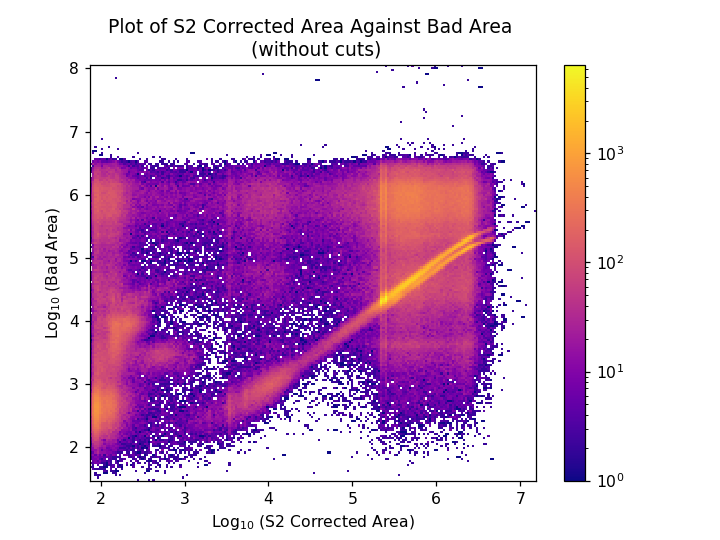

In [267]:
#3. Bad area cut

x = np.log10(arr['S2_corrected_area'])
y = np.log10(arr['evt_bad_area'])

fig, ax = plt.subplots()

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('Log$_{10}$ (S2 Corrected Area)')
plt.ylabel('Log$_{10}$ (Bad Area)')
plt.title('Plot of S2 Corrected Area Against Bad Area \n (without cuts)')
plt.show()

<IPython.core.display.Javascript object>


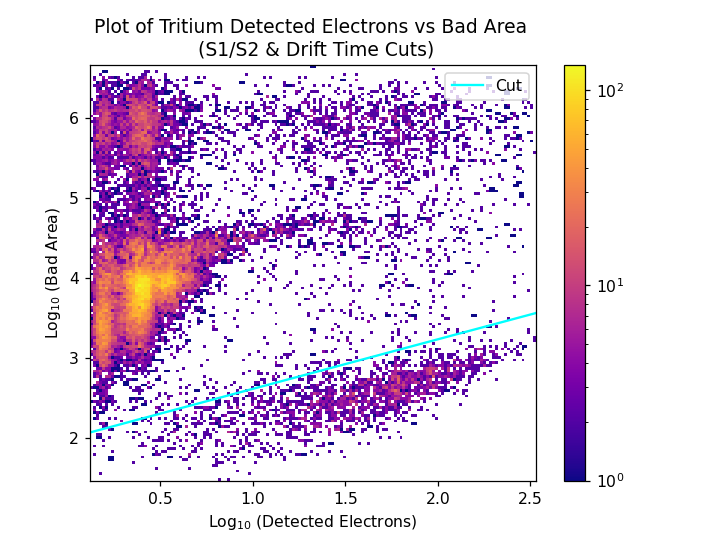

In [268]:
#apply cuts for area and drift time

x = tritium_like_arr['S2_corrected_area'].to_numpy()
x = np.log10(x / 58.5)
y = tritium_like_arr['evt_bad_area'].to_numpy()
y = np.log10(y)
fig, ax = plt.subplots()

line1 = plt.Line2D((0, 2.54), (2,3.57), color = 'cyan', label="Cut")

h = ax.hist2d(x, 
              y,  
              bins=150, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)

plt.xlabel('Log$_{10}$ (Detected Electrons)')
plt.ylabel('Log$_{10}$ (Bad Area)')
plt.title('Plot of Tritium Detected Electrons vs Bad Area \n (S1/S2 & Drift Time Cuts)')
ax.add_line(line1)
plt.legend()
plt.show()

In [269]:
#save cut to Tritium-like array
x = np.array(tritium_like_arr['S2_corrected_area'].to_numpy())
linebadar = line(x, 0.62, 2.125)

tritium_like_arr = tritium_like_arr[(tritium_like_arr['evt_bad_area']<linebadar)]
print("Tritium Array Length (bad area cut: ",len(tritium_like_arr))

Tritium Array Length (bad area cut:  4344


<IPython.core.display.Javascript object>


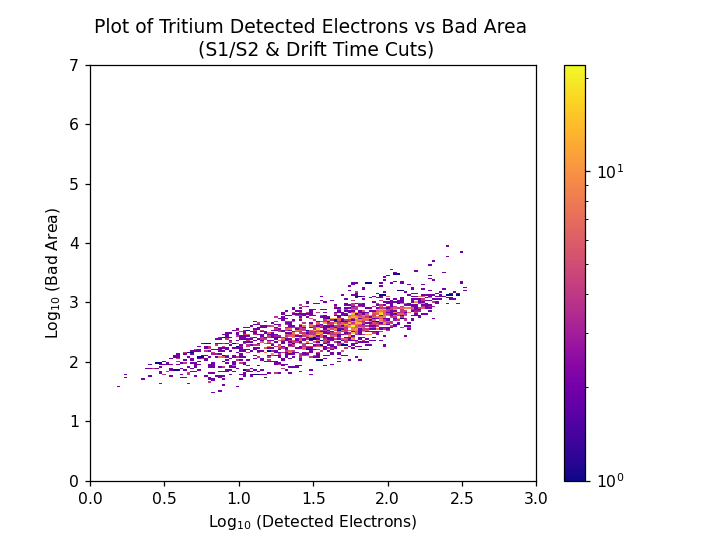

In [290]:
x = tritium_like_arr['S2_corrected_area'].to_numpy()
x = np.log10(x / 58.5)
y = tritium_like_arr['evt_bad_area'].to_numpy()
y = np.log10(y)
fig, ax = plt.subplots()

line1 = plt.Line2D((0, 2.54), (2,3.57), color = 'cyan', label="Cut")

h = ax.hist2d(x, 
              y,  
              bins=100, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)

plt.xlim(0,3)
plt.ylim(0,7)
plt.xlabel('Log$_{10}$ (Detected Electrons)')
plt.ylabel('Log$_{10}$ (Bad Area)')
plt.title('Plot of Tritium Detected Electrons vs Bad Area \n (S1/S2 & Drift Time Cuts)')
#ax.add_line(line1)
#plt.legend()
plt.show()

<IPython.core.display.Javascript object>


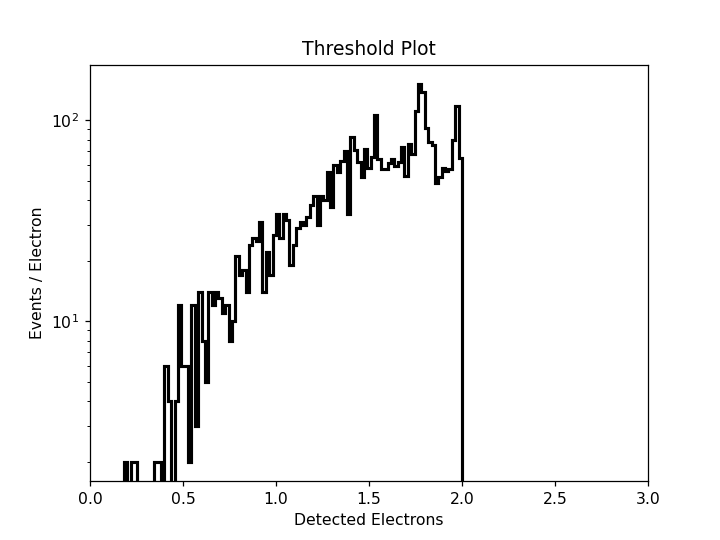

In [291]:
#Threshold cut 
x = tritium_like_arr['S2_corrected_area'].to_numpy()
conditions = (x /58.2) < 100
x = np.log10(x /58.2)

fig, ax = plt.subplots()
h = ax.hist(x[conditions], bins=100, fill = False, histtype='step', linewidth=2, facecolor='c', color = 'black', log = True)

plt.xlim(0,3)

plt.xlabel('Detected Electrons')
plt.ylabel('Events / Electron')
plt.title('Threshold Plot')
plt.show()

## THRESHOLD CUT NOT WORKING

In [280]:
#Threshold Cut NOT WORKING
#Lower limit = 10
#Upper limit = 100
#why doesnt this work
#tritium_like_arr = tritium_like_arr[(tritium_like_arr['S2_corrected_area']/58.2)<100 & ((tritium_like_arr['S2_corrected_area']/58.2)>10)]
print("Tritium Array Length (threshold cut): ", len(tritium_like_arr))

Tritium Array Length (threshold cut):  4344


In [279]:
#Saving Tritium Array to CSV File
#if Helen
tritium_data=tritium_like_arr.to_csv(r'C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data\tritium_data.csv')
#if Trinity
#tritium_data=tritium_like_arr.to_csv(r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project/tritium_data.csv')

## Gate/cathode-like events

1. Apply threshold and bad area cuts 
2.Plot background data width vs drift, select gate (or gate + gas) events and cathode events
3. Consider an S1 vs S2 cut

In [283]:
with uproot.open("bg_sr1_fixed.root") as f:
    bg = f["Events"].arrays(cut = 'S1_corrected_area > 0', library = 'pd')
bg.keys()

Index(['runID', 'evtID', 'S2_area', 'S2_btm_area', 'S2_top_area', 'S2_TBA',
       'S2_corrected_area', 'S2_XY_corrected_area', 'S2_width_ns',
       'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25', 'S2_AFT_50',
       'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns', 'S2_fwhm_ns',
       'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated', 'has_good_S1',
       'drift_time', 'S1_area', 'S1_corrected_area', 'evt_total_area',
       'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area'],
      dtype='object')

In [299]:
#1. Threshold Cut
#Lower limit = 10
#Upper limit = 100
print("Background Length (no cuts): ", len(bg))

bg = bg[((bg['S2_corrected_area'] /58.2) < 100) & ((bg['S2_corrected_area'] /58.2) > 10)]
print("Background Length (threshold cut): ", len(bg))

#Threshold cut doesnt cut?

Background Length (no cuts):  35559
Background Length (threshold cut):  35559


<IPython.core.display.Javascript object>


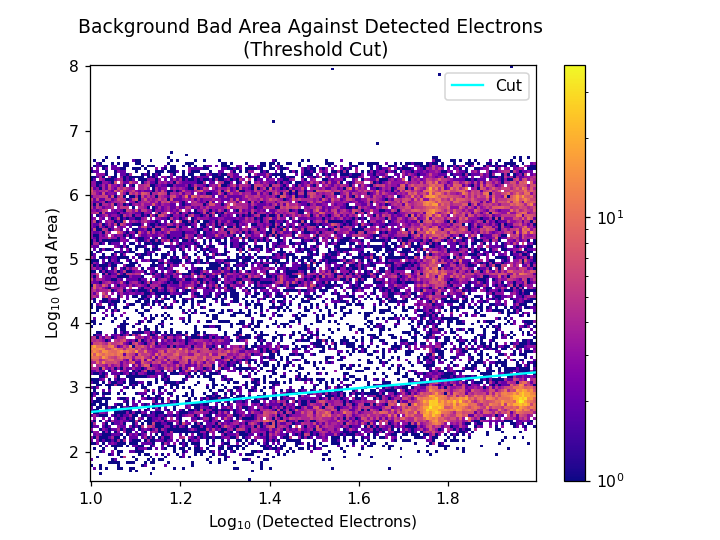

In [300]:
#2. Bad area cut
line1 = plt.Line2D((0, 2.54), (2,3.57), color = 'cyan', label="Cut")

x = bg['S2_corrected_area'].to_numpy()
x = np.log10(x / 58.5)
y = bg['evt_bad_area'].to_numpy()
y = np.log10(y)
fig, ax = plt.subplots()

line1 = plt.Line2D((0, 2.54), (2,3.57), color = 'cyan', label="Cut")

h = ax.hist2d(x, 
              y,  
              bins=150, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)


plt.xlabel('Log$_{10}$ (Detected Electrons)')
plt.ylabel('Log$_{10}$ (Bad Area)')
plt.title('Background Bad Area Against Detected Electrons \n (Threshold Cut)')
ax.add_line(line1)
plt.legend()
plt.show()

In [308]:
def line(x, m, c):
    y = (m * x) + c
    return y

x = np.array(bg['S2_corrected_area'].to_numpy())
linebadar = line(x, 0.25, 2.125)
#linebadar2 = line(x, 0.25, -1)

bg = bg[(bg['evt_bad_area']<linebadar)]

print(len(bg['evt_bad_area']))
#28977

8448


<IPython.core.display.Javascript object>


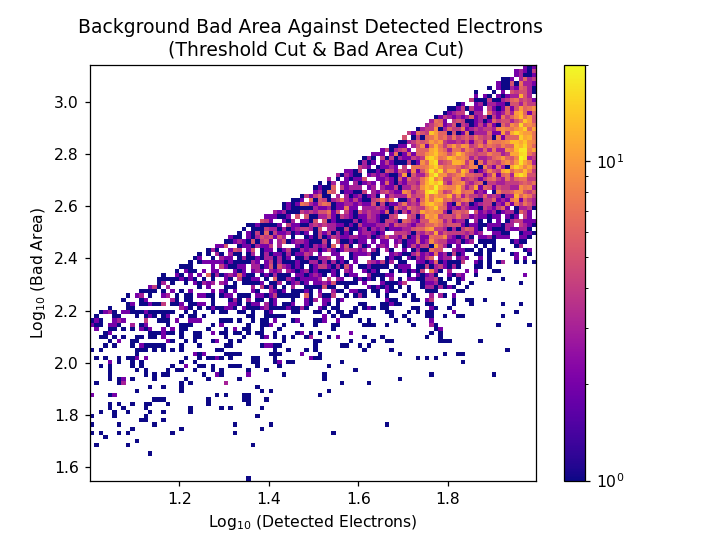

In [310]:
x = bg['S2_corrected_area'].to_numpy()
x = np.log10(x / 58.5)
y = bg['evt_bad_area'].to_numpy()
y = np.log10(y)
fig, ax = plt.subplots()

line1 = plt.Line2D((0, 2.54), (2,3.57), color = 'cyan', label="Cut")

h = ax.hist2d(x, 
              y,  
              bins=100, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)


plt.xlabel('Log$_{10}$ (Detected Electrons)')
plt.ylabel('Log$_{10}$ (Bad Area)')
plt.title('Background Bad Area Against Detected Electrons \n (Threshold Cut & Bad Area Cut)')
plt.show()

<IPython.core.display.Javascript object>


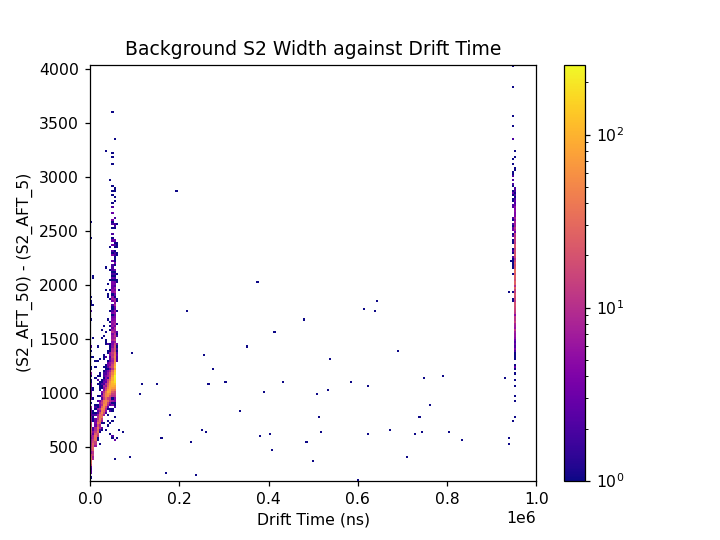

Text(0.5, 1.0, 'Background S2 Width against Drift Time')

In [319]:
#3. Plot background S2 width vs drift time
fig, ax = plt.subplots()
y = bg['S2_AFT_50']-bg['S2_AFT_5']
conditions= (bg['drift_time']<1e6) & (y<5000)

h = ax.hist2d(bg['drift_time'].to_numpy()[conditions],y.to_numpy()[conditions],
              bins=200,cmap = mpl.colormaps['plasma'],norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlim(0,1e6)
plt.xlabel('Drift Time (ns)')
plt.ylabel('(S2_AFT_50) - (S2_AFT_5)')
plt.title('Background S2 Width against Drift Time')

In [325]:
#Drift time cut (Isolating Gate, gas and cathode backgrounds)
gate_arr = bg.copy(deep=True)
gas_arr = bg.copy(deep=True)
cathode_arr = bg.copy(deep=True)
gate_gas_arr = bg.copy(deep=True)

gate_arr = gate_arr[(gate_arr['drift_time']<30000) & (gate_arr['drift_time']>0)]
gas_arr = gas_arr[(gas_arr['drift_time']<57000) & (gas_arr['drift_time']>30000)]
gate_gas_arr = gate_gas_arr[(gate_gas_arr['drift_time']<57000) & (gate_gas_arr['drift_time']>0)]

cathode_arr = cathode_arr[(cathode_arr['drift_time']>900000) & (cathode_arr['drift_time']<980000)]

print("Cathode Length: ",len(cathode_arr))
print("Gate Length: ",len(gate_arr))
print("Gas Length: ",len(gas_arr))
print("Gate-Gas Length: ",len(gate_gas_arr))

Cathode Length:  1021
Gate Length:  1824
Gas Length:  5463
Gate-Gas Length:  7287


In [328]:
#Saving background arrays to CSV File
#if Helen
cathode_data=cathode_arr.to_csv(r'C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data\cathode_data.csv')
gate_data=gate_arr.to_csv(r'C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data\gate_data.csv')
gas_data=gas_arr.to_csv(r'C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data\gas_data.csv')

#if Trinity
#cathode_data=cathode_arr.to_csv(r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project/cathode_data.csv')
#gate_data=gate_like_arr.to_csv(r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project/gate_data.csv')
#gas_data=gas_like_arr.to_csv(r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project/gas_data.csv')

<IPython.core.display.Javascript object>


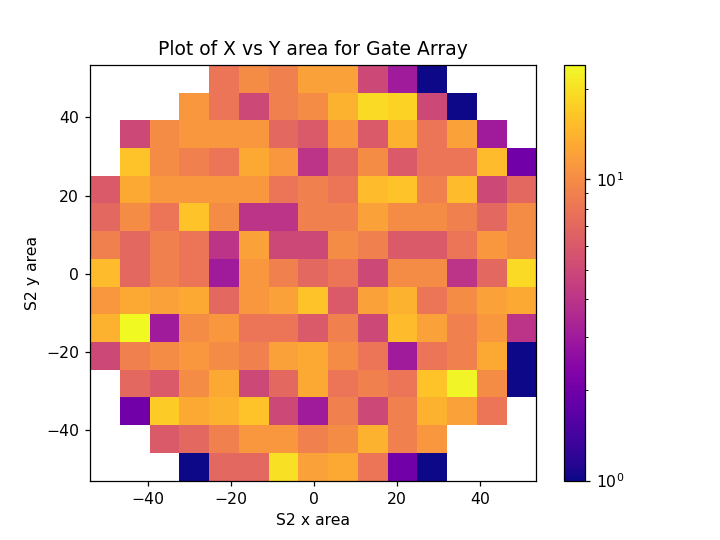

Text(0.5, 1.0, 'Plot of X vs Y area for Gate Array')

In [326]:
x = gate_arr ['S2_x_cm']
y = gate_arr ['S2_y_cm']

fig, ax = plt.subplots()
h = ax.hist2d(x, 
              y,  
              bins=15, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 x area')
plt.ylabel('S2 y area')
plt.title('Plot of X vs Y area for Gate Array')

<IPython.core.display.Javascript object>


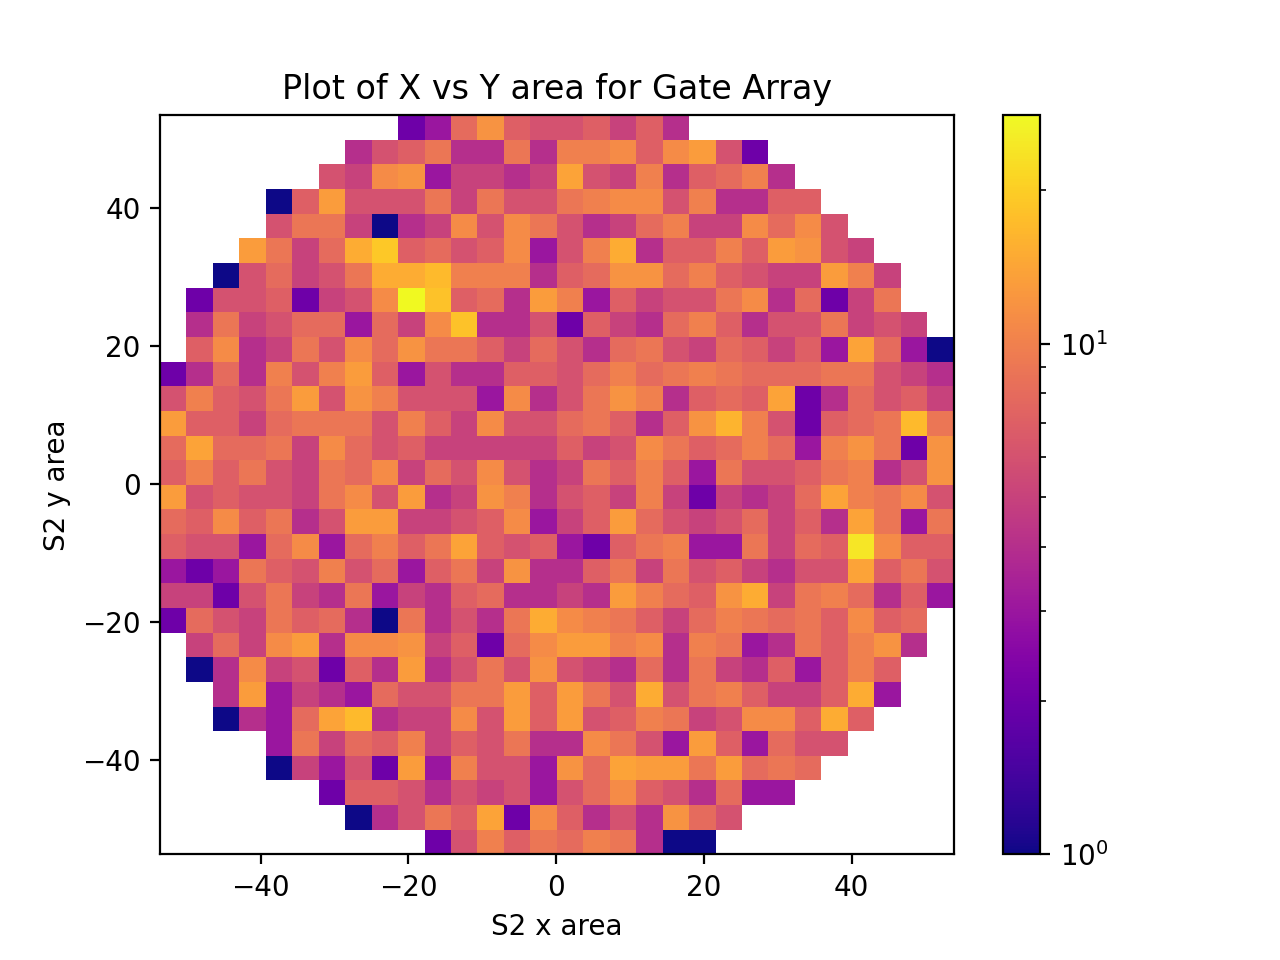

Text(0.5, 1.0, 'Plot of X vs Y area for Gate Array')

In [303]:
x = gas_arr ['S2_x_cm']
y = gas_arr ['S2_y_cm']

fig, ax = plt.subplots()
h = ax.hist2d(x, 
              y,  
              bins=30, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 x area')
plt.ylabel('S2 y area')
plt.title('Plot of X vs Y area for Gate Array')

<IPython.core.display.Javascript object>


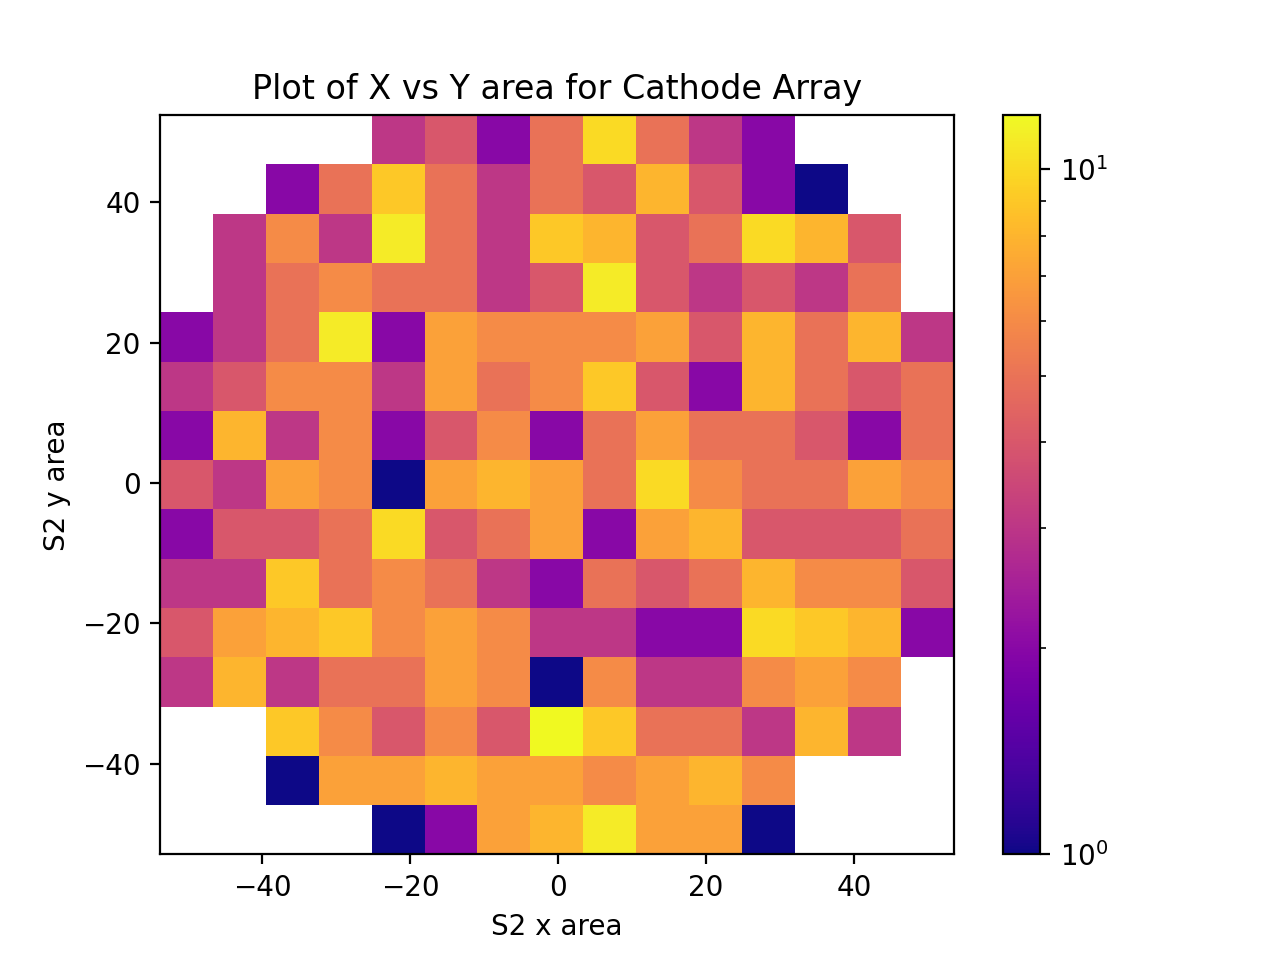

Text(0.5, 1.0, 'Plot of X vs Y area for Cathode Array')

In [304]:
x = cathode_arr ['S2_x_cm']
y = cathode_arr ['S2_y_cm']

fig, ax = plt.subplots()
h = ax.hist2d(x, 
              y,  
              bins=15, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 x area')
plt.ylabel('S2 y area')
plt.title('Plot of X vs Y area for Cathode Array')

<IPython.core.display.Javascript object>


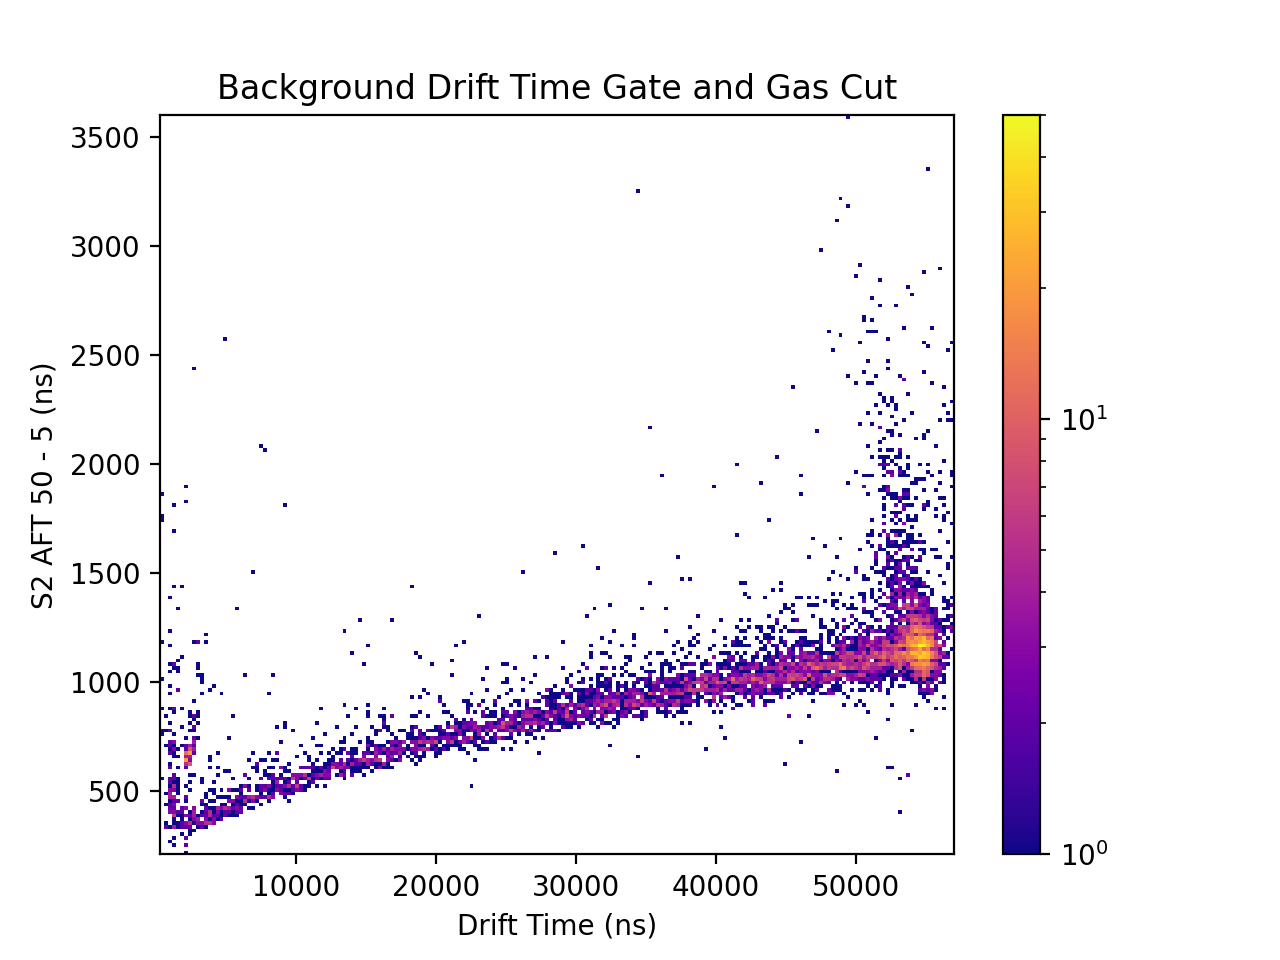

In [305]:
#1. Plot background date width vs drift
fig, ax = plt.subplots()
y = gate_gas_arr['S2_AFT_50'] - gate_gas_arr['S2_AFT_5']
conditions= (y<5000)
h = ax.hist2d(gate_gas_arr['drift_time'][conditions],y[conditions],
              bins=200,cmap = mpl.colormaps['plasma'],norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

#plt.xlim(0,1e6)
#plt.ylim(0,0.2e6)
plt.xlabel('Drift Time (ns)')
plt.ylabel('S2 AFT 50 - 5 (ns)')
plt.title('Background Drift Time Gate and Gas Cut')
plt.show()

<IPython.core.display.Javascript object>


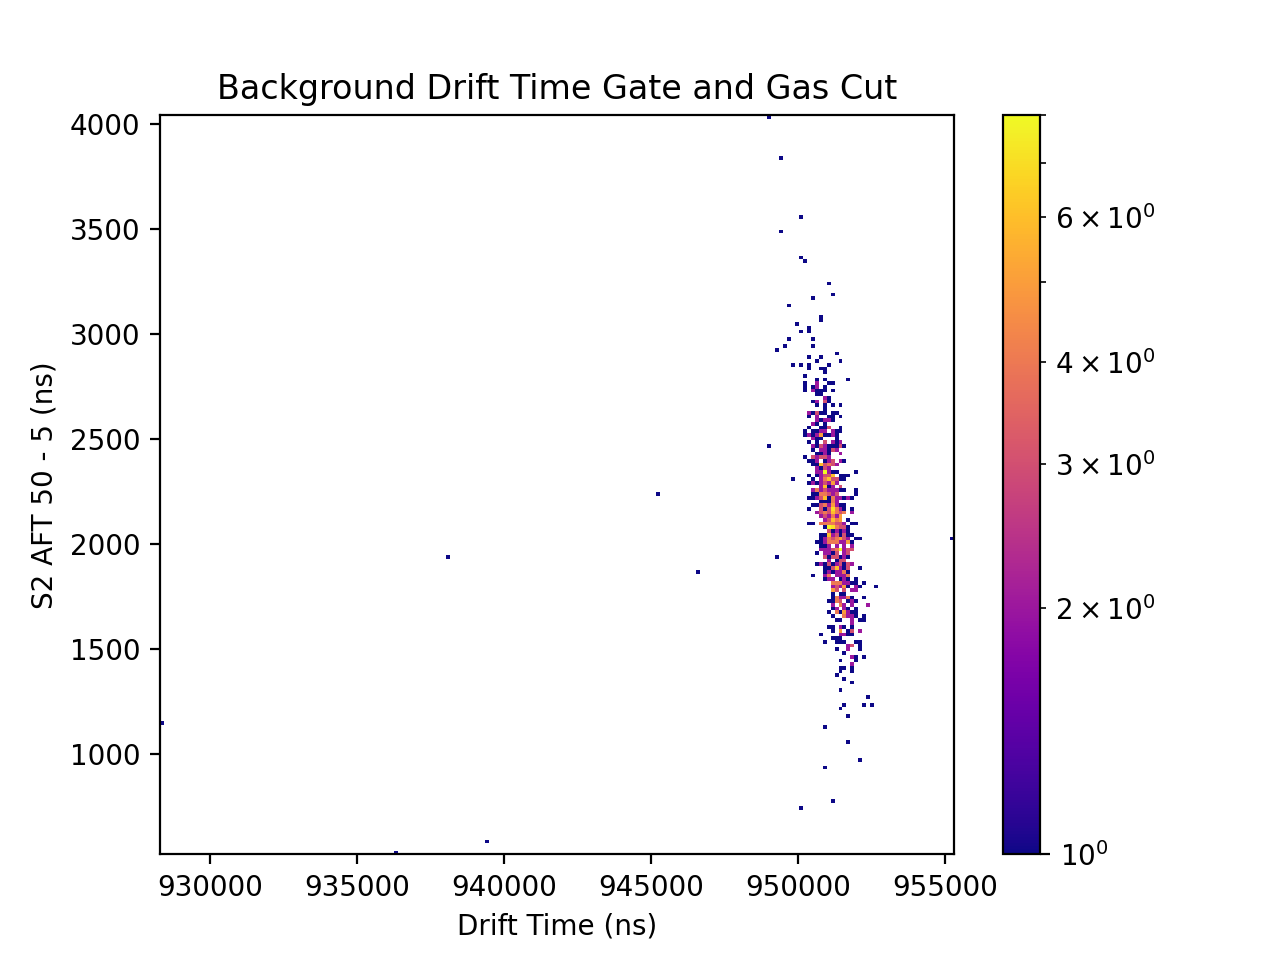

In [306]:
#1. Plot background date width vs drift
fig, ax = plt.subplots()
y = cathode_arr['S2_AFT_50'] - cathode_arr['S2_AFT_5']
conditions= (y<5000)
h = ax.hist2d(cathode_arr['drift_time'][conditions],y[conditions],
              bins=200,cmap = mpl.colormaps['plasma'],norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

#plt.xlim(0,1e6)
#plt.ylim(0,0.2e6)
plt.xlabel('Drift Time (ns)')
plt.ylabel('S2 AFT 50 - 5 (ns)')
plt.title('Background Drift Time Gate and Gas Cut')
plt.show()